<a href="https://colab.research.google.com/github/aryamansrivastava/Drowsiness_Detection-system/blob/main/Drowsiness_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

--2021-02-07 07:01:15--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.1’

shape_predictor_68_ 100%[===================>]  61.07M  7.07MB/s    in 18s     

2021-02-07 07:01:33 (3.36 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.1’ saved [64040097/64040097]



Unzip the model and overwrite the zipped file.

In [ ]:
!bunzip2 -d '/content/shape_predictor_68_face_landmarks.dat.bz2'

bunzip2: Output file /content/shape_predictor_68_face_landmarks.dat already exists.


Install all your dependencies and make the required import statements.

In [ ]:
!pip install dlib

In [ ]:
!pip install playsound

In [ ]:
!pip install pygame

In [ ]:
import numpy as np
import dlib
import cv2
from google.colab.patches import cv2_imshow
import threading
from threading import Thread
import imutils
from imutils import face_utils
from scipy.spatial import distance as dist
import pygame

Helper methods that sound an alarm and measure the eye aspect ratio.

In [ ]:
def sound_alarm():
    pygame.mixer.init()
    pygame.mixer.music.load("path")
    pygame.mixer.music.play()

In [ ]:
def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])   #vertical distance
    C = dist.euclidean(eye[0], eye[3])   #horizontal distance

    ear = (A + B) / (2.0 * C)
    return ear

In [ ]:
EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 40

COUNTER = 0
ALARM_ON = False

Locate the model and load it.

In [ ]:
predictor_path = '/content/shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

In [ ]:
# Grab the indexes of the facial landmarks for the left and right eye, respectively
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart , rEnd) =face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

The following two cells are only for use on Colab. Use these to take a photo with your computer's webcam.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='my_photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

NotFoundError: Requested device not found


In [ ]:
def detect_drowsiness(image_path):

  frame = cv2.imread(image_path, cv2.IMREAD_COLOR)

  frame = imutils.resize(frame, width=450)
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 0)
  COUNTER = 0

  for rect in rects:
      shape = predictor(gray, rect)         # determine the facial landmarks for face region
      shape = face_utils.shape_to_np(shape) #converting to numpy array

      leftEye = shape[lStart:lEnd]
      rightEye = shape[rStart:rEnd]

      leftEAR = eye_aspect_ratio(leftEye)
      rightEAR = eye_aspect_ratio(rightEye)

      ear = (leftEAR + rightEAR) / 2.0

      leftEyeHull = cv2.convexHull(leftEye)
      rightEyeHull = cv2.convexHull(rightEye)
      cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
      cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

      if ear < EYE_AR_THRESH:
          COUNTER += 1

          if COUNTER >= EYE_AR_CONSEC_FRAMES:
              if not ALARM_ON:
                  ALARM_ON = True
                  d=threading.Thread(target=sound_alarm)
                  d.setDaemon(True)
                  d.start()

          cv2.putText(frame, "DROWSINESS ALERT!Rest Recommended", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

      else:
          COUNTER = 0
          ALARM_ON = False
          cv2.putText(frame, "All safe! You are Wide Awake", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

  cv2_imshow(frame)

In [ ]:
!wget https://previews.123rf.com/images/arminstaudt/arminstaudt1602/arminstaudt160200137/52649686-portrait-of-a-teenage-boy-with-closed-eyes.jpg -O photo1.jpg

--2021-02-07 07:01:44--  https://previews.123rf.com/images/arminstaudt/arminstaudt1602/arminstaudt160200137/52649686-portrait-of-a-teenage-boy-with-closed-eyes.jpg
Resolving previews.123rf.com (previews.123rf.com)... 65.9.83.93, 65.9.83.11, 65.9.83.40, ...
Connecting to previews.123rf.com (previews.123rf.com)|65.9.83.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119405 (117K) [image/jpeg]
Saving to: ‘photo1.jpg’

photo1.jpg          100%[===================>] 116.61K   520KB/s    in 0.2s    

2021-02-07 07:01:45 (520 KB/s) - ‘photo1.jpg’ saved [119405/119405]



In [ ]:
!wget https://previews.123rf.com/images/cotobealk/cotobealk0601/cotobealk060100012/304468-wide-open-eyes-of-a-little-girl.jpg -O photo2.jpg

--2021-02-07 07:01:45--  https://previews.123rf.com/images/cotobealk/cotobealk0601/cotobealk060100012/304468-wide-open-eyes-of-a-little-girl.jpg
Resolving previews.123rf.com (previews.123rf.com)... 65.9.83.93, 65.9.83.11, 65.9.83.40, ...
Connecting to previews.123rf.com (previews.123rf.com)|65.9.83.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146356 (143K) [image/jpeg]
Saving to: ‘photo2.jpg’

photo2.jpg          100%[===================>] 142.93K   566KB/s    in 0.3s    

2021-02-07 07:01:46 (566 KB/s) - ‘photo2.jpg’ saved [146356/146356]



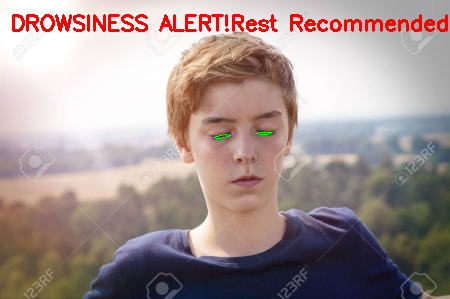

In [ ]:
detect_drowsiness('/content/photo1.jpg')

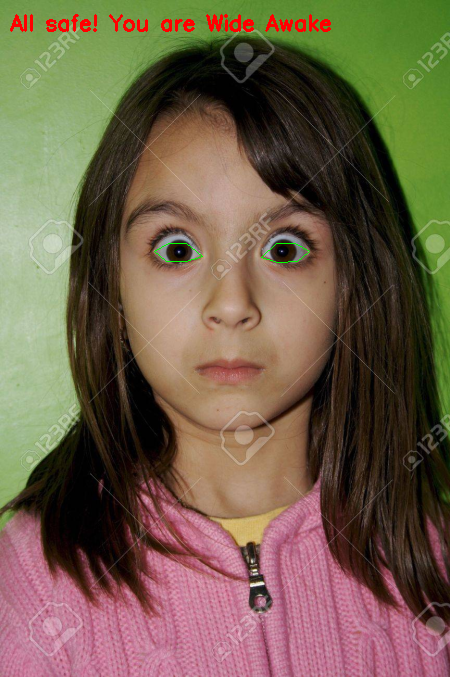

In [ ]:
detect_drowsiness('/content/photo2.jpg')

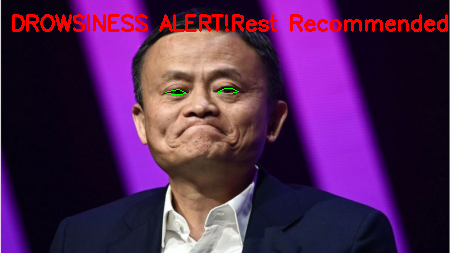

In [ ]:
detect_drowsiness('/content/photo3.jpg')